Forecasted Volatility for the last day in the horizon:
h.1    1.239168
h.2    1.241557
h.3    1.239037
h.4    1.240605
h.5    1.243572
Name: 2023-11-06 00:00:00-05:00, dtype: float64


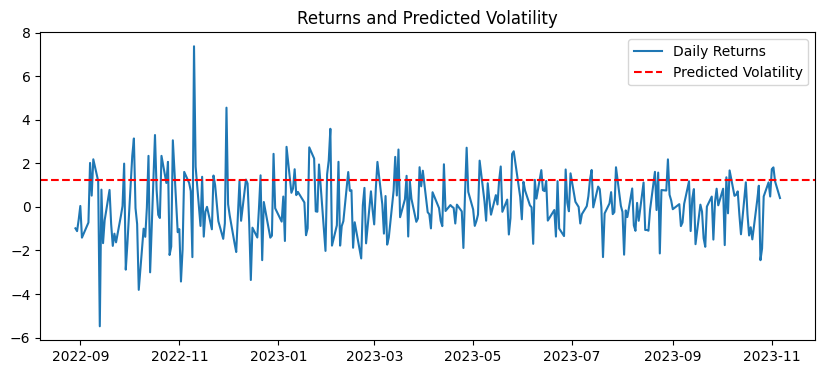

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import datetime

# Download historical data for a stock
tickerSymbol = 'qqq'
data = yf.Ticker(tickerSymbol)
data = data.history(period='1d', start='2013-1-1', end='2023-11-07')

# Drop any rows that are completely NA
data.dropna(how='all', inplace=True)

# Calculate daily returns and drop the first NA
data['returns'] = 100 * data['Close'].pct_change().dropna()

# Check for infinite values which can happen if there is a 0 in close prices somehow
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows with NA values created by percentage change
data.dropna(inplace=True)

# Define the GARCH model
garch_model = arch_model(data['returns'], vol='Garch', p=1, q=1)

# Fit the model with try-except to catch errors
try:
    garch_fit = garch_model.fit(disp='off')  # Suppress optimization output

    # Forecast the volatility for the next 5 days
    forecasts = garch_fit.forecast(horizon=5, method='simulation')

    # Get the last day forecast
    last_day_forecast = forecasts.variance.iloc[-1]**0.5  # square root of variance

    # Ensure that we have finite values
    if np.all(np.isfinite(last_day_forecast)):

        # Print the forecasted volatility
        print("Forecasted Volatility for the last day in the horizon:")
        print(last_day_forecast)

        # Plot the last 100 days of returns and the forecasted volatility level
        plt.figure(figsize=(10, 4))
        plt.plot(data.index[-300:], data['returns'][-300:], label='Daily Returns')
        plt.title('Returns and Predicted Volatility')

        # Plot a horizontal line for the predicted volatility on the last day
        plt.axhline(y=last_day_forecast.values[-1], color='r', linestyle='--', label='Predicted Volatility')
        plt.legend()
        plt.show()
    else:
        print("The forecasted volatility contains non-finite values and cannot be plotted.")

except Exception as e:
    print(f"An error occurred: {e}")


Forecasted Volatility: 1.24%


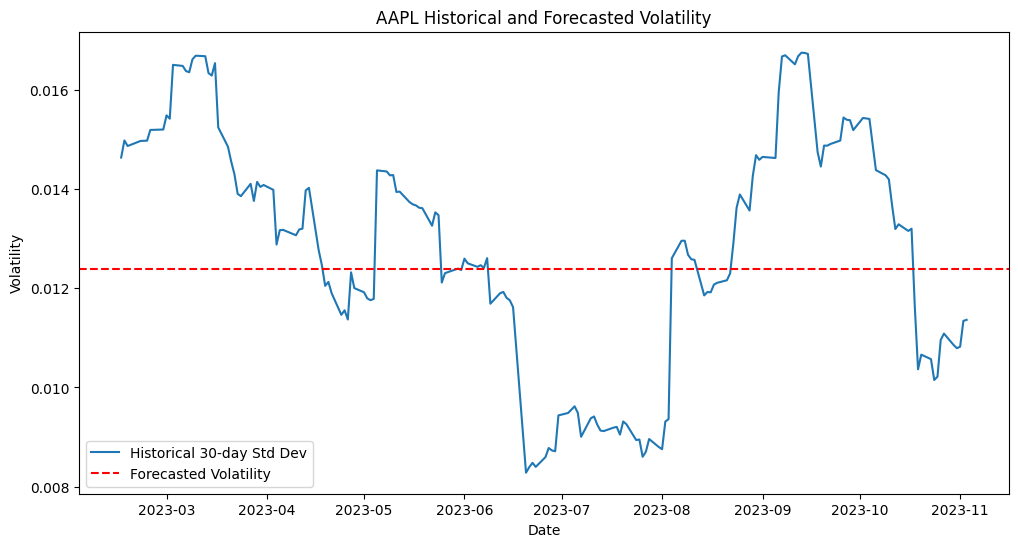

In [15]:
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
import numpy as np
import datetime

def get_historical_volatility(ticker_symbol, start_date, end_date):
    data = yf.Ticker(ticker_symbol).history(period='1d', start=start_date, end=end_date)
    data.dropna(how='all', inplace=True)
    data['returns'] = 100 * data['Close'].pct_change().dropna()
    data['volatility'] = data['returns'].rolling(window=30).std()
    return data/100

def get_garch_forecasted_volatility(ticker_symbol, start_date, end_date):
    # Fetch the historical data
    data = yf.Ticker(ticker_symbol).history(period='1d', start=start_date, end=end_date)
    data.dropna(how='all', inplace=True)
    
    # Calculate daily returns and multiply by 100 to express as percentage
    data['returns'] = data['Close'].pct_change().dropna() * 100
    
    # Remove infinite values and drop remaining NAs
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)
    
    # Fit the GARCH model
    garch_model = arch_model(data['returns'], vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    
    # Forecast the next day's variance
    forecasts = garch_fit.forecast(horizon=1)
    
    # Take the square root of the forecasted variance to get the standard deviation
    last_day_volatility = np.sqrt(forecasts.variance.iloc[-1])
    
    # Since we scaled the returns by 100, we need to scale back the volatility
    last_day_volatility_scaled = last_day_volatility / 100
    
    # Return the last day's forecasted daily volatility as a percentage
    return last_day_volatility_scaled.values[-1]

# Example usage of the functions
ticker_symbol = 'AAPL'
start_date = '2023-1-1'
end_date = '2023-11-04'
historical_data = get_historical_volatility(ticker_symbol, start_date, end_date)

# Get the forecasted volatility from GARCH
forecasted_volatility = get_garch_forecasted_volatility(ticker_symbol, start_date, end_date)
print(f"Forecasted Volatility: {forecasted_volatility:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['volatility'], label='Historical 30-day Std Dev')
plt.axhline(y=forecasted_volatility, color='r', linestyle='--', label='Forecasted Volatility')
plt.title('AAPL Historical and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [16]:
import datetime
from scipy.optimize import fmin
from scipy.stats import norm
import numpy as np

# Assuming today's date is November 7, 2023, for this example
current_date = datetime.datetime(2023, 11, 8)
expiration_date = datetime.datetime(2023, 11, 17)

# Provided data
S = 221.81  # Latest AAPL stock price
X = 225 # Strike price
r = 0.04  # Risk-free interest rate (annually)
T = (expiration_date - current_date).days / 365  # Time to expiration in years
cm = 5.68  # Market price of the option

# Adjusted function for a call option
def ImpliedVolatilityCall(s):
    d1 = ((np.log(S/X) + (r + 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
    d2 = ((np.log(S/X) + (r - 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    val = (call_price - cm)**2
    print("[σ]=", s, ", Objective Function Value:", val)
    return val

# Initial guess for the volatility
initial_sigma = [0.3]  # Starting with an initial guess of 30%

# Using fmin to minimize the objective function and find the implied volatility
s = fmin(ImpliedVolatilityCall, initial_sigma, disp=0)  # Set disp=0 to not print iterations

# The result from fmin will be the implied volatility
iv_call = s[0]
print(f"Implied Volatility (Call): {iv_call:.2%}")

# Let's say you have an annualized forecasted volatility from your GARCH model.
# You need to convert the daily forecasted volatility to an annualized number for comparison.
daily_forecasted_volatility = 1.531336 / 100  # Example value from your GARCH output
annualized_forecasted_volatility = daily_forecasted_volatility * np.sqrt(252)

print(f"Annualized Forecasted Volatility: {annualized_forecasted_volatility:.2%}")

# Determine trading signals based on the forecasted and implied volatility
if annualized_forecasted_volatility > iv_call:
    print("Buy Signal: The GARCH model predicts higher volatility than the market implies.")
elif annualized_forecasted_volatility < iv_call:
    print("Sell Signal: The GARCH model predicts lower volatility than the market implies.")
else:
    print("No clear signal: The market's implied volatility matches the GARCH model's prediction.")


[σ]= [0.3] , Objective Function Value: 7.851752973547506
[σ]= [0.315] , Objective Function Value: 6.760753536606308
[σ]= [0.33] , Objective Function Value: 5.74800844282753
[σ]= [0.345] , Objective Function Value: 4.814750260890189
[σ]= [0.375] , Objective Function Value: 3.190661655371203
[σ]= [0.405] , Objective Function Value: 1.8949773105543262
[σ]= [0.465] , Objective Function Value: 0.306478546172752
[σ]= [0.525] , Objective Function Value: 0.07442847360402934
[σ]= [0.645] , Objective Function Value: 3.7323924704445726
[σ]= [0.465] , Objective Function Value: 0.306478546172752
[σ]= [0.585] , Objective Function Value: 1.213450833753588
[σ]= [0.495] , Objective Function Value: 0.019808664170868157
[σ]= [0.465] , Objective Function Value: 0.306478546172752
[σ]= [0.51] , Objective Function Value: 0.004350366112055238
[σ]= [0.525] , Objective Function Value: 0.07442847360402934
[σ]= [0.5025] , Objective Function Value: 0.0013997826199182337
[σ]= [0.495] , Objective Function Value: 0.0

In [17]:
# from scipy.optimize import fmin
# from scipy.stats import norm
# import numpy as np

# # Provided data
# S = 176.65  # Latest VOO stock price
# X = 175  # Strike price
# r = 0.04  # Risk-free interest rate (annually)
# T = (expiration_date - current_date).days / 365  # Time to expiration in years
# cm = 3.1  # Market price of the option

# # Adjusted function for a call option
# def ImpliedVolatilityCall(s):
#     d1 = ((np.log(S/X) + (r + 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
#     d2 = ((np.log(S/X) + (r - 0.5 * s[0]**2) * T) / (s[0] * np.sqrt(T)))
#     call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
#     val = (call_price - cm)**2
#     print("[σ]=", s, ", Object Function Value:", val)
#     return val

# # Initial guess for the volatility
# initial_sigma = [0.3]  # Starting with an initial guess of 30%

# # Using fmin to minimize the objective function and find the implied volatility
# s = fmin(ImpliedVolatilityCall, initial_sigma)

# # The result from fmin will be the implied volatility
# iv_call = s[0]
# print(f"Implied Volatility (Call): {iv_call:.2%}")


Now add Barclay's strat